<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

Загрузим и просмотрим исходные данные:

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Проверим наличие дубликатов:

In [ ]:
data.duplicated().sum()

0

Изменим тип данных столбца с датой и временем с object на
datetime64 и установим его в качестве индекса:

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены даты и время:

In [ ]:
data.index.is_monotonic

True

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим наличие пропусков:

In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

Выполним ресемплирование по одному часу:

In [ ]:
data = data.resample('1H').sum()

## Анализ

Разложим временной ряд на три составляющие: тренд, сезонность и остаток и построим соответсвующие графики:

In [ ]:
decomposed = seasonal_decompose(data)

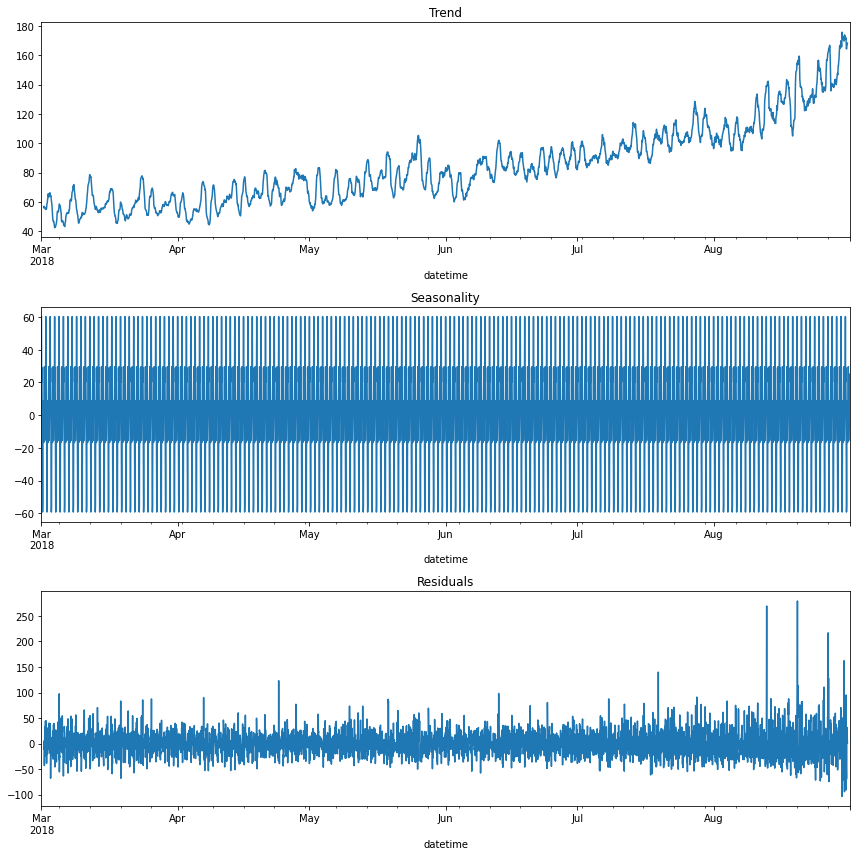

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда, показывает возрастающий тренд, указывает на то, что число клиентов такси увеличивается со временем. График сезонности, в свою очередь, является мало информативным в представленном виде. Построим также график тренда за последний известный полный день, чтобы увидеть изменение по часам:

Text(0.5, 1.0, 'Trend')

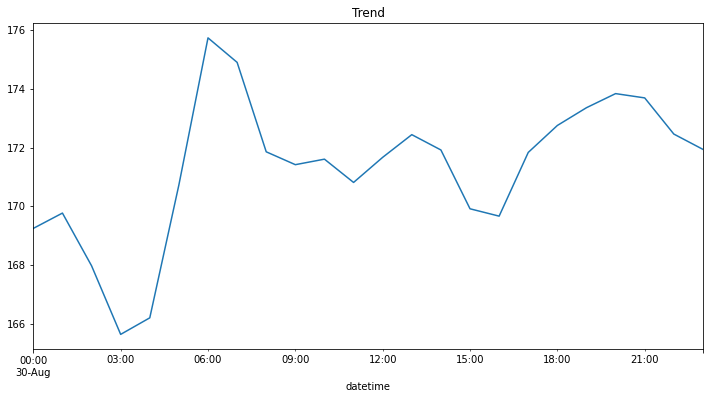

In [ ]:
plt.figure(figsize=(12, 6))

decomposed.trend['2018-08-30'].plot(ax=plt.gca())
plt.title('Trend')


Наблюдается тенденция к снижению числа заказов такси к середине ночи и резкое увеличение к 6 утра. Посмотрим также на график сезонности за последнюю неделю:

Text(0.5, 1.0, 'Seasonality')

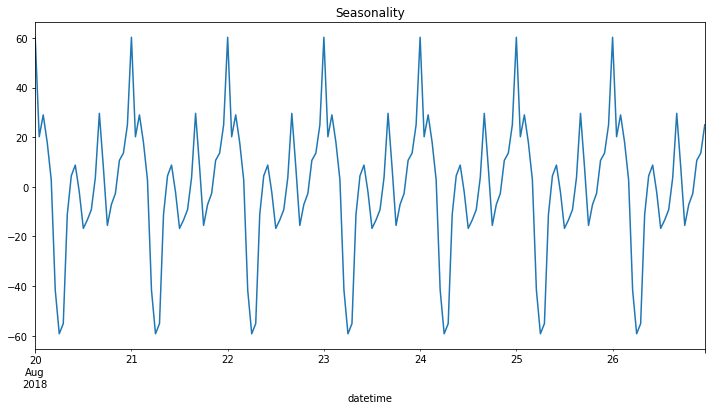

In [ ]:
plt.figure(figsize=(12, 6))

decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Seasonality')

График сезонности такде показывет наличия повторяющегося уменьшение числа заказов в ночное время и увеличение в утренние и вечерние часы.

In [ ]:
data_resample_day = data.resample('1D').sum()

In [ ]:
decomposed_rd = seasonal_decompose(data_resample_day)

Text(0.5, 1.0, 'Seasonality')

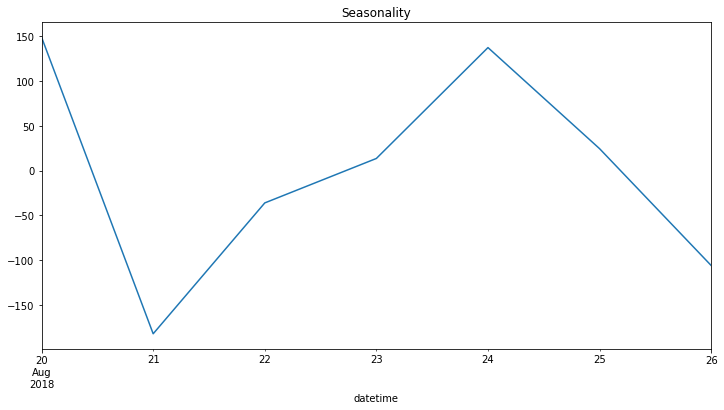

In [ ]:
plt.figure(figsize=(12, 6))

decomposed_rd.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Seasonality')

<div class="alert alert-info">
На данном графике можно заметить максимальное количество заказов такси по понедельникам и пятницам, а минимальное число заказов во вторник. Можно сделать вывод о наличи недельной сезонности
</div>

## Обучение

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания признаков:

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data, 140, 15)
data = data.dropna()

In [ ]:
data.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-06 20:00:00,83,1,20,48.0,51.0,52.0,42.0,63.0,40.0,42.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,40.533333
2018-03-06 21:00:00,58,1,21,83.0,48.0,51.0,52.0,42.0,63.0,40.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,43.666667
2018-03-06 22:00:00,81,1,22,58.0,83.0,48.0,51.0,52.0,42.0,63.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.066667
2018-03-06 23:00:00,47,1,23,81.0,58.0,83.0,48.0,51.0,52.0,42.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,51.800000
2018-03-07 00:00:00,100,2,0,47.0,81.0,58.0,83.0,48.0,51.0,52.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,53.266667
2018-03-07 01:00:00,121,2,1,100.0,47.0,81.0,58.0,83.0,48.0,51.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,56.466667
2018-03-07 02:00:00,24,2,2,121.0,100.0,47.0,81.0,58.0,83.0,48.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,61.133333
2018-03-07 03:00:00,66,2,3,24.0,121.0,100.0,47.0,81.0,58.0,83.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,59.533333
2018-03-07 04:00:00,73,2,4,66.0,24.0,121.0,100.0,47.0,81.0,58.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,61.200000


Разделим данные на обучающую и тестовую выборки:

In [ ]:
random_state = 12345

In [ ]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

print(features.shape)
print(target.shape)

(4276, 143)
(4276,)


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    shuffle=False,
    test_size=0.1
)

print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)

(3848, 143)
(3848,)
(428, 143)
(428,)


Подберем гиперпараметры для рассматриваемых моделей:

Случайный лес:

In [ ]:
%%time

model_rf = RandomForestRegressor(random_state=random_state)

tscv = TimeSeriesSplit(n_splits=3)

parameters = {
    'n_estimators': range (10, 51, 10),
    'max_depth': range (1,13, 2),
}

grid_rf = GridSearchCV(model_rf, parameters, cv=tscv, scoring='neg_root_mean_squared_error', verbose=True)
grid_rf.fit(features_train, target_train)

print(grid_rf.best_params_)
grid_rf.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'max_depth': 11, 'n_estimators': 50}
CPU times: user 2min 43s, sys: 151 ms, total: 2min 43s
Wall time: 2min 43s


-25.523028760454036

CatBoost:

In [ ]:
%%time

model_cb = CatBoostRegressor(random_state=random_state)

tscv = TimeSeriesSplit(n_splits=3)

parameters = {
    'depth':  range (1, 13, 2),
    'learning_rate': [0.1],
    'iterations': [100, 200, 300]
}

grid_cb = GridSearchCV(model_cb, parameters, cv=tscv, scoring='neg_root_mean_squared_error', verbose=True)
grid_cb.fit(features_train, target_train, verbose=10)

print(grid_cb.best_params_)
grid_cb.best_score_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 28.5866070	total: 2.69ms	remaining: 266ms
10:	learn: 23.5660548	total: 26ms	remaining: 210ms
20:	learn: 21.1011252	total: 49.5ms	remaining: 186ms
30:	learn: 19.8632464	total: 72.6ms	remaining: 162ms
40:	learn: 19.1396876	total: 95.6ms	remaining: 138ms
50:	learn: 18.6371972	total: 119ms	remaining: 114ms
60:	learn: 18.2612286	total: 142ms	remaining: 90.8ms
70:	learn: 18.0013864	total: 160ms	remaining: 65.4ms
80:	learn: 17.7684716	total: 176ms	remaining: 41.3ms
90:	learn: 17.5211193	total: 194ms	remaining: 19.2ms
99:	learn: 17.3236538	total: 213ms	remaining: 0us
0:	learn: 31.8542619	total: 2.54ms	remaining: 251ms
10:	learn: 26.1719651	total: 23.3ms	remaining: 189ms
20:	learn: 23.4922990	total: 48.1ms	remaining: 181ms
30:	learn: 22.0763629	total: 72ms	remaining: 160ms
40:	learn: 21.1152773	total: 96.3ms	remaining: 139ms
50:	learn: 20.4867670	total: 116ms	remaining: 111ms
60:	learn: 20.0698873	total: 145ms	remaining: 92.

-24.563864019553247

LightGBM:

In [ ]:
%%time

model_lgb = LGBMRegressor(random_state=random_state)

tscv = TimeSeriesSplit(n_splits=3)

parameters = {
    'num_leaves': [10, 30],
    'learning_rate': [0.1],
    'n_estimators': [100, 200]
}

grid_lgb = GridSearchCV(model_lgb, parameters, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_lgb.fit(features_train, target_train, verbose=10)

print(grid_lgb.best_params_)
grid_lgb.best_score_

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. 

{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 30}
CPU times: user 57min 13s, sys: 36.9 s, total: 57min 50s
Wall time: 58min 7s


-25.480140725357746

<div class="alert alert-info">
Лучшее качество показала модель CatBoost с параметрами 'depth': 3, 'iterations': 200, 'learning_rate': 0.1
</div>

## Тестирование

Проверим качество лучшей модели (CatBoost) на тестовой выборке:

In [ ]:
#model_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=random_state)
#model_rf.fit(features_train, target_train)

#pred_rf = model_rf.predict(features_test)
#rmse_rf = mean_squared_error(target_test, pred_rf) ** 0.5
#print(rmse_rf)

In [ ]:
model_cb = CatBoostRegressor(random_state=random_state, loss_function='RMSE', **grid_cb.best_params_)
model_cb.fit(features_train, target_train)

pred_cb = model_cb.predict(features_test, verbose=10)
rmse_cb = mean_squared_error(target_test, pred_cb) ** 0.5
print(rmse_cb)

0:	learn: 37.1606369	total: 11.3ms	remaining: 2.24s
1:	learn: 35.5759588	total: 25.4ms	remaining: 2.52s
2:	learn: 34.1957846	total: 40.2ms	remaining: 2.64s
3:	learn: 32.9658729	total: 55.1ms	remaining: 2.7s
4:	learn: 31.9111302	total: 72.5ms	remaining: 2.83s
5:	learn: 30.9355533	total: 87.4ms	remaining: 2.83s
6:	learn: 30.1321160	total: 102ms	remaining: 2.82s
7:	learn: 29.2903153	total: 116ms	remaining: 2.79s
8:	learn: 28.6504430	total: 130ms	remaining: 2.77s
9:	learn: 28.0687219	total: 145ms	remaining: 2.75s
10:	learn: 27.4527489	total: 159ms	remaining: 2.72s
11:	learn: 26.9116876	total: 172ms	remaining: 2.69s
12:	learn: 26.4364070	total: 183ms	remaining: 2.63s
13:	learn: 26.0257917	total: 193ms	remaining: 2.56s
14:	learn: 25.6960052	total: 206ms	remaining: 2.54s
15:	learn: 25.3480219	total: 217ms	remaining: 2.49s
16:	learn: 25.0504310	total: 227ms	remaining: 2.44s
17:	learn: 24.8286557	total: 241ms	remaining: 2.44s
18:	learn: 24.6168195	total: 254ms	remaining: 2.42s
19:	learn: 24.439

In [ ]:
#model_lgbmr = LGBMRegressor(random_state=random_state, **grid_lgb.best_params_, n_jobs=-1)
#model_lgbmr.fit(features_train, target_train)

#pred_lgbmr = model_lgbmr.predict(features_test)
#rmse_lgbmr = mean_squared_error(target_test, pred_lgbmr) ** 0.5
#print(rmse_lgbmr)

Значение RMSE модели CatBoost на тестовой выбборке равно 40.2, что меньше заданного порога в 48.